Camera calibration from chessboard then applying that into the road image 

Next thing is to discover the bird view (aka perspective transform) into the road image. That requires marking the area of interest and 4 points of the images. 

lane curvature by using masking and thersholding techniques. 
Then birdviews to fit a polynomial to the lane lines. 
Extract the curvature lines from this polynomials left and right lane:using this formula: f(y) = Ay^2 + By + C, where A, B, and C are coefficients.
perspective transform on the z coordinate, or distance from the camera, the smaller it will appear in a 2D image. 
* This helps us to match a car's location directly
Compute the perspective transform, M, given source and destination points:


RGB vs HSV vs HLS: from the previous lesson, yellow lane are harder to detect, yet HLS represent different ways to measure the lightness and value. 
H and S stay stable under shadow or exesscive brightness that will be more reliable than RGB 


To do :

#finding the pixal lane and detection by :
1. histogram plot 
2. sliding window
3. polyfit

#Detect lane pixels and fit to find the lane boundary.
#Determine the curvature of the lane and vehicle position with respect to center.
#Warp the detected lane boundaries back onto the original image.
#Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


* need to loop all image undistort 
* applied thershold 
* lane detection 
* calculation lane distance 
* apply lane color



In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
#matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

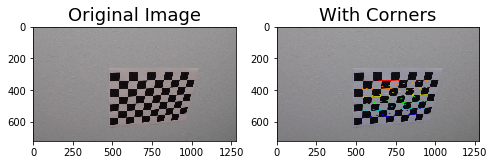

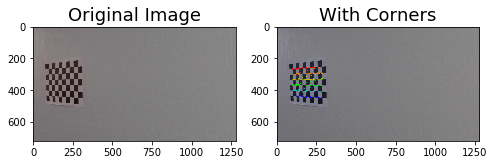

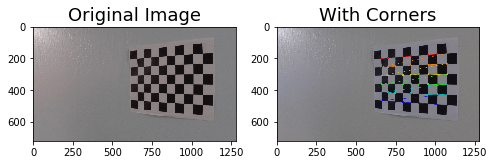

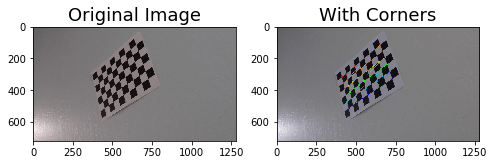

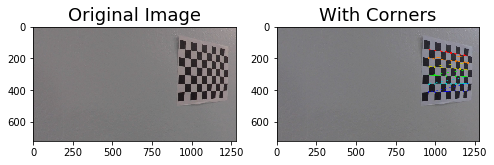

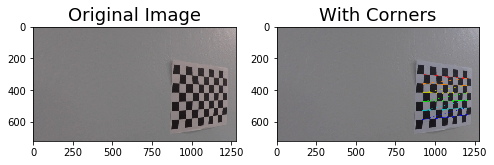

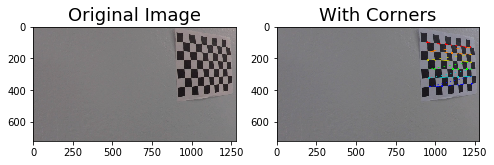

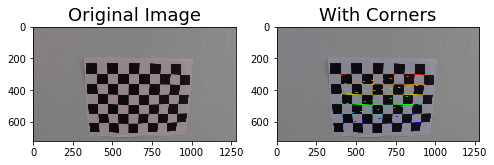

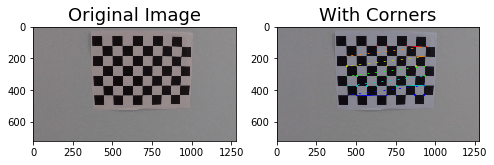

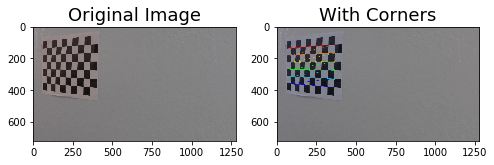

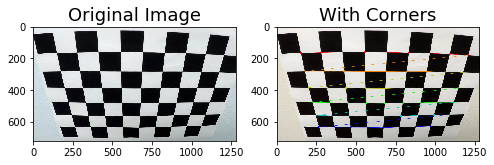

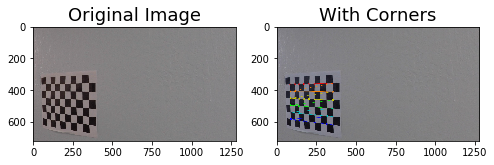

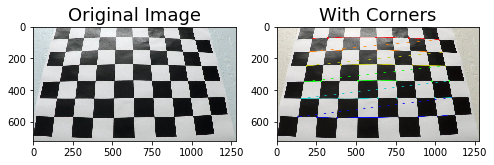

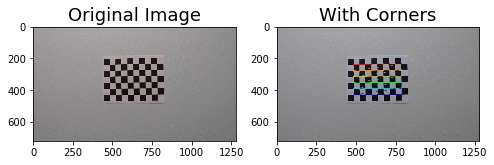

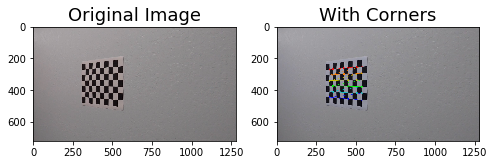

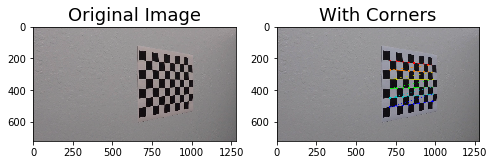

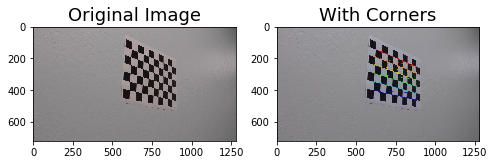

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

In [3]:
print(objp.shape)
print(corners.shape)

(54, 3)
(54, 1, 2)


Applying undistortion and see how does it fits on the images
Mark the area that wants to be undistorted from the distorded images

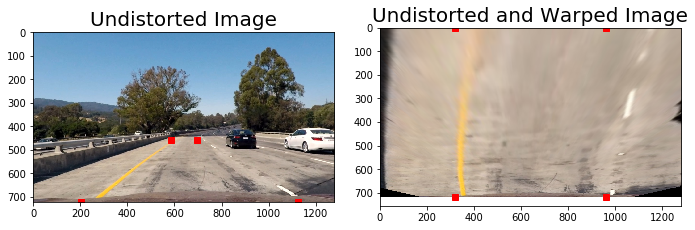

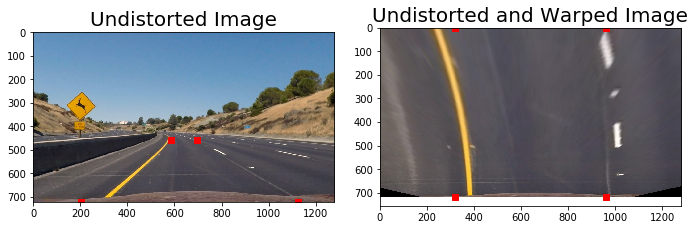

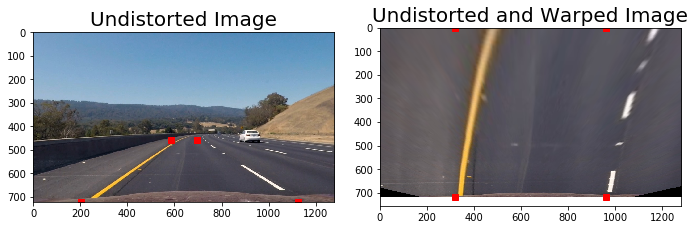

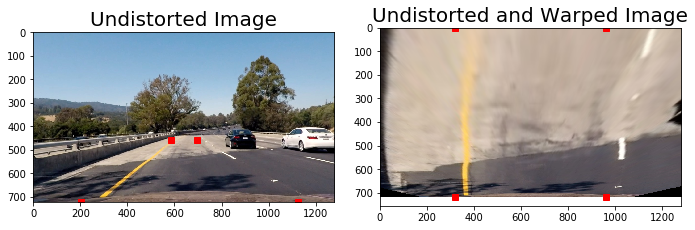

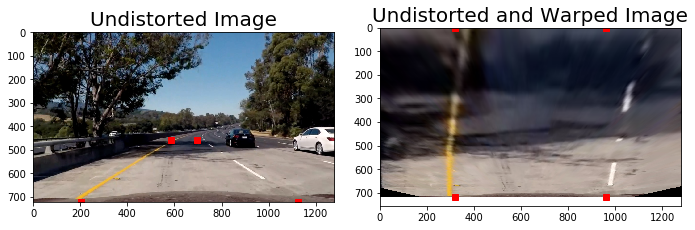

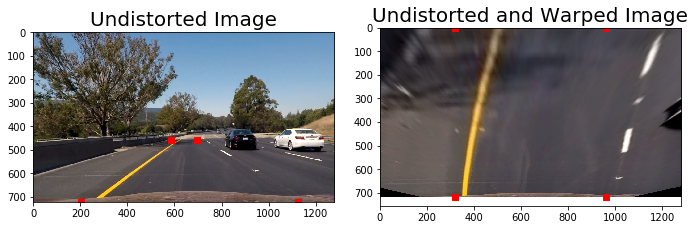

In [4]:
img = cv2.imread("test_images/test3.jpg")
def undistort(img):
    img = cv2.imread(img)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def bird_view(img):
    undist = undistort(img)
    img_size = (undist.shape[1], undist.shape[0])
    #src are the positions of 4 points in the original image that should form a regatangular shape
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    #src = np.float32([[220, 720],[1110, 720],[570, 470],[722, 470]])
    #src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
  
    #dst points is the positions of those 4 src points after the perspective transform.
    #dst = np.float32([[320,720],[920,720],[920,1],[320,1]])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
    #dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    #undistorted and plotting the four points 
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    for i in range(4):
        ax1.plot(src[i][0],src[i][1],'rs') 
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=20)

    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    for i in range(4):
        ax2.plot(dst[i][0],dst[i][1],'rs')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return warped, M 
for image in glob.glob('test_images/test*.jpg'):
    bird_view(image)

In [5]:


def threshold(img,r_thresh=(210, 255), s_thresh=(120, 255), sx_thresh=(20, 100)):
    img, M = bird_view(img)

#with the help of OpenCV. it would be as simple as one liner 
#converting each of them into their channel
    B = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] 
    L = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    S = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
#Sober X
    #sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
#apply thershold to theirs accordingly 
    B_bin = np.zeros_like(B)
    B_bin[(B >= 155) & (B <= 200)] = 1
    
    L_bin = np.zeros_like(L)
    L_bin[(L >= 225) & (L <= 255)] = 1    
   
    S_bin = np.zeros_like(S)
    S_bin[(S >= 180) & (S <= 255)] = 1
        
#stack them over 
    Stacked = np.zeros_like(S_bin)
    Stacked[(L_bin == 1) | (B_bin == 1)] = 1 
    binary_warped = Stacked

# Combine the two binary thresholds (i did this very well on the first few transformation, until the part where I need to calculate the lane and it doesnt work)
    #binary_warped = np.zeros_like(sxbinary)
    #binary_warped[(Stacked == 1) | (sxbinary == 1)] = 1  
    f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
    f.tight_layout()
        
    ax1.set_title('Original Image', fontsize=16)
    ax1.imshow(cv2.cvtColor(undistort(image),cv2.COLOR_BGR2RGB))
        
    ax2.set_title('Warped Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

    ax3.set_title('b binary threshold', fontsize=16)
    ax3.imshow(B, cmap='gray')
    
    ax4.set_title('l binary threshold', fontsize=16)
    ax4.imshow(L, cmap='gray')  

    ax3.set_title('s binary threshold', fontsize=16)
    ax5.imshow(S, cmap='gray')

    ax6.set_title('Combined color thresholds', fontsize=16)
    ax6.imshow(Stacked, cmap='gray')

    return binary_warped


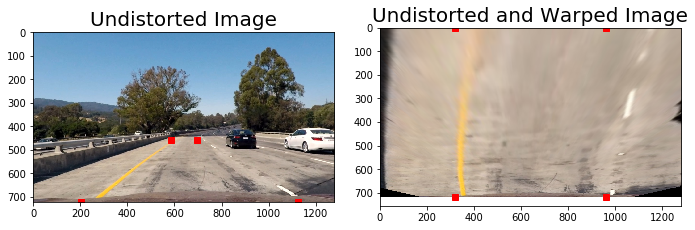

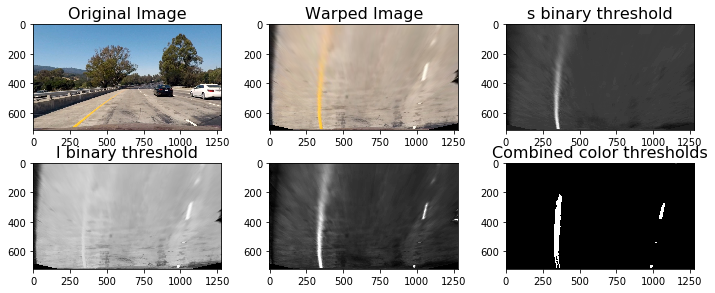

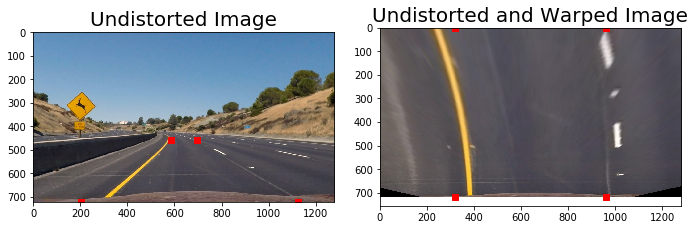

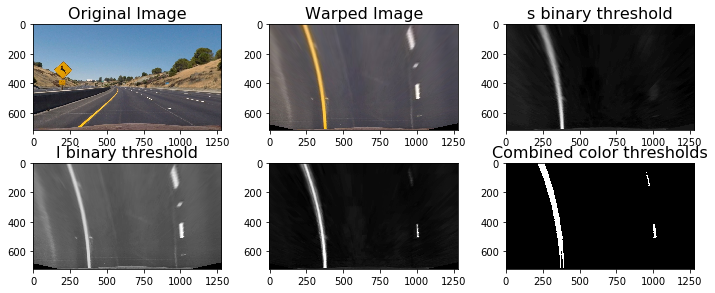

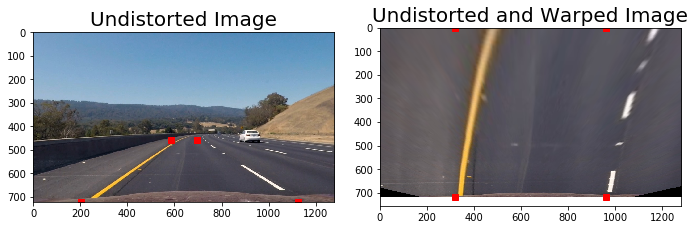

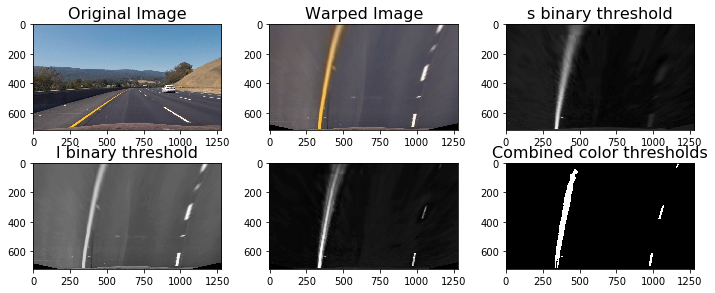

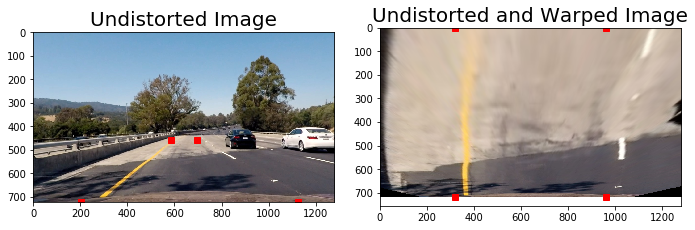

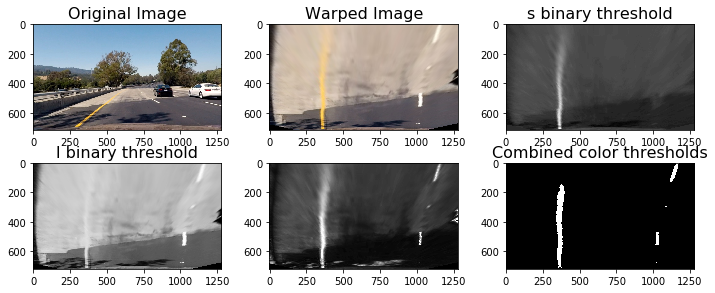

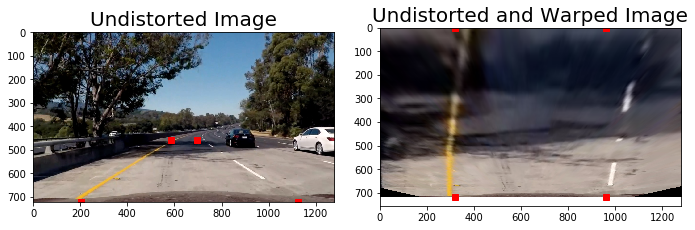

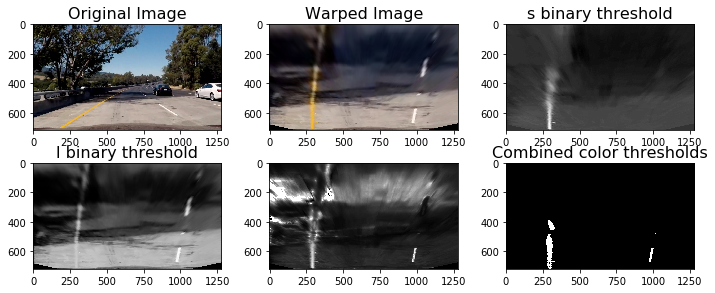

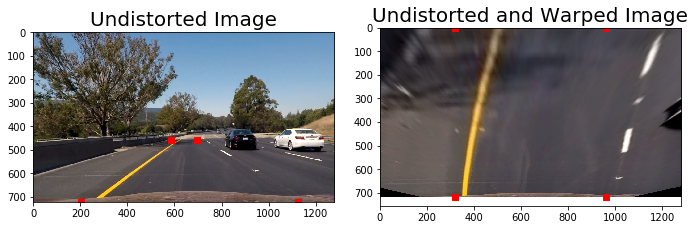

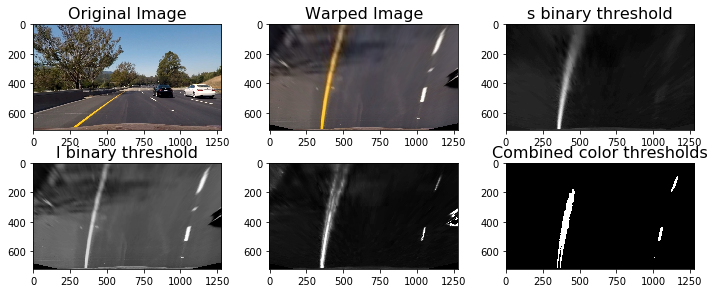

In [6]:
for image in glob.glob('test_images/test*.jpg'):
    threshold(image)

In [17]:
def undistort(img):
    img = cv2.imread(img)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def bird_view(img):
    undist = undistort(img)
    img_size = (undist.shape[1], undist.shape[0])
    #src are the positions of 4 points in the original image that should form a regatangular shape
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    #src = np.float32([[220, 720],[1110, 720],[570, 470],[722, 470]])
    #src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],[((img_size[0] / 6) - 10), img_size[1]],[(img_size[0] * 5 / 6) + 60, img_size[1]],[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32([[(img_size[0] / 4), 0],[(img_size[0] / 4), img_size[1]],[(img_size[0] * 3 / 4), img_size[1]],[(img_size[0] * 3 / 4), 0]])
  
    #dst points is the positions of those 4 src points after the perspective transform.
    #dst = np.float32([[320,720],[920,720],[920,1],[320,1]])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
    #dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    #undistorted and plotting the four points 
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    for i in range(4):
        ax1.plot(src[i][0],src[i][1],'rs') 
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Undistorted Image', fontsize=20)

    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Sliding window detection', fontsize=20)
    for i in range(4):
        ax2.plot(dst[i][0],dst[i][1],'rs')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return warped, M 

def threshold(img,r_thresh=(210, 255), s_thresh=(120, 255), sx_thresh=(20, 100)):
    img, M = bird_view(img)

#with the help of OpenCV. it would be as simple as one liner 
#converting each of them into their channel
    B = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] 
    L = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    S = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
#Sober X
    #sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
#apply thershold to theirs accordingly 
    B_bin = np.zeros_like(B)
    B_bin[(B >= 155) & (B <= 200)] = 1
    
    L_bin = np.zeros_like(L)
    L_bin[(L >= 225) & (L <= 255)] = 1    
   
    S_bin = np.zeros_like(S)
    S_bin[(S >= 180) & (S <= 255)] = 1
        
#stack them over 
    binary_warped = np.zeros_like(S_bin)
    binary_warped[(L_bin == 1) | (B_bin == 1)] = 1 
    return binary_warped

def slidingWindowLineDetection(img):
    binary_warped = threshold(img)
#Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

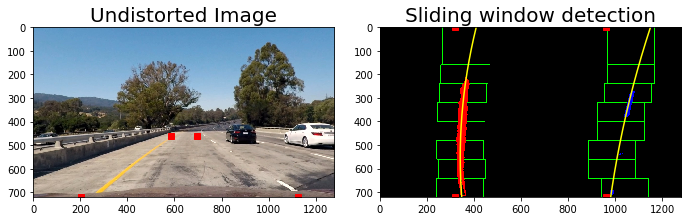

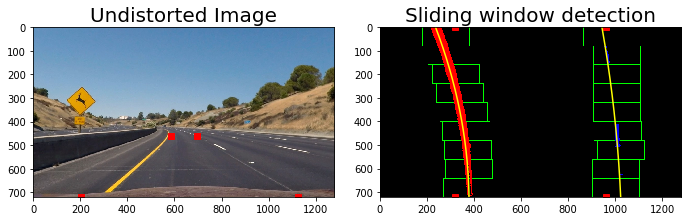

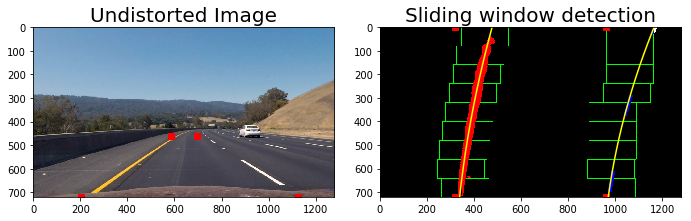

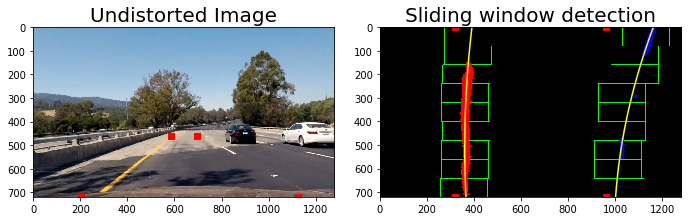

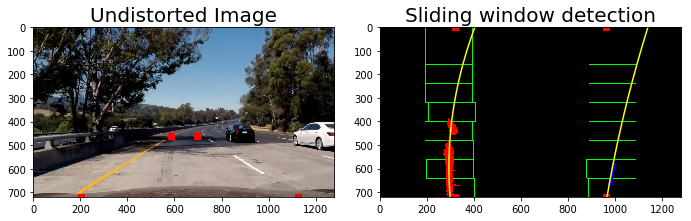

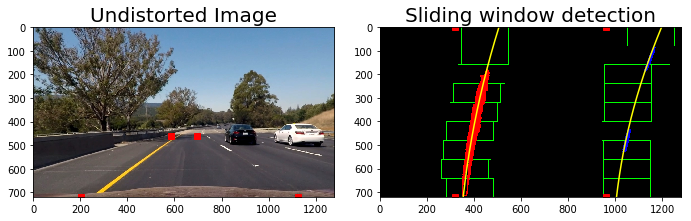

In [18]:
for image in glob.glob('test_images/test*.jpg'):
    slidingWindowLineDetection(image)

In [22]:
def LaneDetection(img):
        # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    binary_warped = threshold(img)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

UnboundLocalError: local variable 'left_fit' referenced before assignment

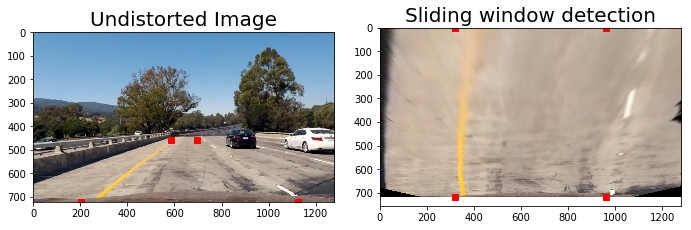

In [23]:
for image in glob.glob('test_images/test*.jpg'):
    LaneDetection(image)

In [19]:
def measuringCurve(img):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images


    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('left_curverad:', left_curverad, 'in m','right_curverad:', right_curverad, 'in m')

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('left_curverad:', left_curverad, 'in m', 'right_curverad:', right_curverad, ' in m')
    return ploty, left_fitx, right_fitx